In [77]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
import json
from nltk.stem import PorterStemmer
from sklearn import linear_model
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhengz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [6]:
users_reviews = [l for l in parse("review-Hawaii_10.json.gz")]
businesses = [l for l in parse("meta-Hawaii.json.gz")]

## Linear Regression

### Feature Engineering

In [9]:
#user avg rating
user_ratings = {}

for review in users_reviews:
    user_id = review.get('user_id')
    rating = review.get('rating')

    if user_id is not None and rating is not None:
        if user_id not in user_ratings:
            user_ratings[user_id] = {'total_rating': 0, 'count': 0}
        
        user_ratings[user_id]['total_rating'] += rating
        user_ratings[user_id]['count'] += 1

user_avg_ratings = {user_id: data['total_rating'] / data['count'] 
                    for user_id, data in user_ratings.items() if data['count'] > 0}

for user_id in list(user_avg_ratings.keys())[:5]:
    print(f"User ID: {user_id}, Average Rating: {user_avg_ratings[user_id]:.2f}")

User ID: 113965417079576625433, Average Rating: 4.91
User ID: 116655819137293331166, Average Rating: 4.73
User ID: 100834119994550070853, Average Rating: 4.94
User ID: 103207214144482097315, Average Rating: 4.64
User ID: 108526171163172578599, Average Rating: 3.48


In [10]:
#businuess img count
image_counts = {}

for review in users_reviews:
    gmap_id = review.get('gmap_id')
    images = review.get('pics')

    if gmap_id and images:
        num_images = len(images)
        if gmap_id in image_counts:
            image_counts[gmap_id] += num_images
        else:
            image_counts[gmap_id] = num_images

In [11]:
response_counts = {}

for review in users_reviews:
    gmap_id = review.get('gmap_id')
    response = review.get('resp')

    if gmap_id and response:
        if gmap_id in response_counts:
            response_counts[gmap_id] += 1
        else:
            response_counts[gmap_id] = 1

In [12]:
users_data = [{'user_id': d['user_id'], 'gmap_id': d['gmap_id'], 'rating': d['rating'],'text': d['text']} 
              for d in users_reviews if 'user_id' in d and 'gmap_id' in d and 'rating' in d and 'text' in d]

business_dict = {d['gmap_id']: {'avg_rating': d.get('avg_rating', 0), 
                                'num_of_reviews': d.get('num_of_reviews', 0)}
                 for d in businesses if 'gmap_id' in d}

In [13]:
features = [{'user_id': d['user_id'], 'gmap_id': d['gmap_id'], 'text': d['text'], 
             'user_avg_rating': user_avg_ratings[d['user_id']], 
             'response_count': response_counts.get(d['gmap_id'], 0), 
             'image_counts': image_counts.get(d['gmap_id'], 0),
             'bus_avg_rating': business_dict[d['gmap_id']]['avg_rating'], 
             'num_of_reviews': business_dict[d['gmap_id']]['num_of_reviews']}
            for d in users_reviews if 'user_id' in d and 'gmap_id' in d and 'rating' in d and 'text' in d]
labels = [d['rating'] for d in users_reviews if 'user_id' in d and 'gmap_id' in d and 'rating' in d and 'text' in d]
    

In [14]:
random.seed(12345)
combined = list(zip(features, labels))
random.shuffle(combined)
features[:], labels[:] = zip(*combined)

In [15]:
features[0]

{'user_id': '118019878707665188743',
 'gmap_id': '0x7eaad5b76010bf61:0xd3730662460d3b4f',
 'text': 'Absolutely Beautiful! Stunning one of a kind views and Amazing eats! Enjoy!',
 'user_avg_rating': 5.0,
 'response_count': 3,
 'image_counts': 24,
 'bus_avg_rating': 4.2,
 'num_of_reviews': 326}

In [16]:
def MSE(predictions, labels):
    differences = [(x - y) ** 2 for x, y in zip(predictions, labels)]
    return sum(differences) / len(differences)

In [17]:
def MAE(predictions, labels):
    differences = [abs(x - y) for x, y in zip(predictions, labels)]
    return sum(differences) / len(differences)

In [18]:
# split dataset
split_index = int(len(features) * 0.9)
train_features = features[:split_index]
test_features = features[split_index:]
train_labels = labels[:split_index]
test_labels = labels[split_index:]

### Baseline Model 1: avg_rating

In [19]:
# extract features
train_X = [[1, d['bus_avg_rating']] for d in train_features]
test_X = [[1, d['bus_avg_rating']] for d in test_features]
train_y = train_labels
test_y = test_labels

In [20]:
# train model
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(train_X, train_y)
predictions = model.predict(test_X)

In [21]:
mse = MSE(predictions, test_y)
mse

0.7849375126098747

### Baseline Model 2: user_avg_rating

In [22]:
train_X = [[1, d['user_avg_rating']] for d in train_features]
test_X = [[1, d['user_avg_rating']] for d in test_features]
train_y = train_labels
test_y = test_labels

In [23]:
# train model
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(train_X, train_y)
predictions = model.predict(test_X)

In [24]:
mse = MSE(predictions, test_y)
mse

0.6205286094204722

### Model 3: avg_rating, user_avg_rating

In [25]:
train_X = [[1, d['user_avg_rating'], d['bus_avg_rating']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating']] for d in test_features]
train_y = train_labels
test_y = test_labels

In [26]:
# train model
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(train_X, train_y)
predictions = model.predict(test_X)

In [27]:
mse = MSE(predictions, test_y)
mse

0.5779212048040041

### Model 4: avg_rating, user_avg_rating, num_of_reviews

In [28]:
train_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews']] for d in test_features]
train_y = train_labels
test_y = test_labels

In [29]:
# train model
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(train_X, train_y)
predictions = model.predict(test_X)

In [30]:
mse = MSE(predictions, test_y)
mse

0.5779095125296335

### Model 5

In [31]:
train_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews'], d['image_counts']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews'], d['image_counts']] for d in test_features]
train_y = train_labels
test_y = test_labels

In [32]:
# train model
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(train_X, train_y)
predictions = model.predict(test_X)

In [33]:
mse = MSE(predictions, test_y)
mse

0.5779080405709329

### Bag of Words

In [34]:
# lowercase, punctuation removed, no stemming
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

for d in train_features:
    if d['text']:
        r = ''.join([c for c in d['text'].lower() if not c in punctuation])
        ws = [w for w in r.split() if w not in stop_words]
        for w in ws:
            wordCount[w] += 1
            
len(wordCount)

314214

In [35]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort(reverse=True)
words = [x[1] for x in counts[:1000]]

#### Sentiment analysis

In [36]:
wordID = dict(zip(words, range(len(words))))
wordSet = set(words)

In [37]:
def feature(datum):
    feat = [0]*len(words)
    if datum['text']:
        r = ''.join([c for c in datum['text'].lower() if not c in punctuation])
        ws = [w for w in r.split() if w not in stop_words]
        for w in ws:
            if w in words:
                feat[wordID[w]] += 1
    feat.append(1) #offset
    return feat

In [38]:
train_X = [feature(d) for d in train_features]
train_y = train_labels
test_X = [feature(d) for d in test_features]
test_y = test_labels

In [39]:
# regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(train_X, train_y)
theta = clf.coef_
train_predictions = clf.predict(train_X)
test_predictions = clf.predict(test_X)

In [40]:
train_mse = MSE(train_predictions, train_y)
test_mse = MSE(test_predictions, test_y)
print(f'train mse: {train_mse}')
print(f'test mse: {test_mse}')

train mse: 0.7009751590499728
test mse: 0.7022344526102418


In [41]:
train_mae = MAE(train_predictions, train_y)
test_mae = MAE(test_predictions, test_y)
print(f'train mae: {train_mae}')
print(f'test mae: {test_mae}')

train mae: 0.6593291216053079
test mae: 0.65877210138101


In [42]:
wordSort = list(zip(theta, words))
wordSort.sort()

In [43]:
wordSort[:50]

[(-1.3239778414247008, 'worst'),
 (-1.1645308903755467, 'horrible'),
 (-1.1046226861936168, 'terrible'),
 (-1.104192620365061, 'rude'),
 (-1.0730716517719194, 'poor'),
 (-0.9501498528332684, 'overpriced'),
 (-0.8315912719418993, 'dirty'),
 (-0.7424156052747342, 'homeless'),
 (-0.7074464417866744, 'slow'),
 (-0.5496295167027502, 'ok'),
 (-0.49249488279725534, 'expensive'),
 (-0.47875570418655533, 'average'),
 (-0.4774893083044798, 'sad'),
 (-0.4772129140865597, 'okay'),
 (-0.4415355238179926, 'closed'),
 (-0.411415271314807, 'priced'),
 (-0.4082870219944519, 'nothing'),
 (-0.39655162786195475, 'dry'),
 (-0.38462913371728724, 'bad'),
 (-0.38304317798066156, 'waited'),
 (-0.3762771784460679, 'salty'),
 (-0.36004594122741723, 'disappointed'),
 (-0.3334659388616416, 'empty'),
 (-0.3141791499229165, 'needs'),
 (-0.3010148950902437, 'tourist'),
 (-0.29456002757383826, 'loud'),
 (-0.2922551606390337, 'money'),
 (-0.286851518342076, 'pricey'),
 (-0.26403607131293816, 'unfortunately'),
 (-0.2615

### Data Visualization

In [44]:
user_avg_ratings = [f['user_avg_rating'] for f in features]
bus_avg_ratings = [f['bus_avg_rating'] for f in features]
num_of_reviews = [f['num_of_reviews'] for f in features]
response_counts = [f['response_count'] for f in features]
image_counts = [f['image_counts'] for f in features]
ratings = [review['rating'] for review in users_reviews if 'rating' in review]

Text(0.5, 1.0, 'User Average Rating Distribution')

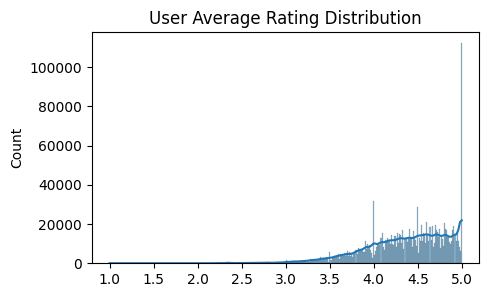

In [45]:
plt.figure(figsize=(5, 3))
sns.histplot(user_avg_ratings, kde=True)
plt.title('User Average Rating Distribution')

Text(0.5, 1.0, 'Business Average Rating Distribution')

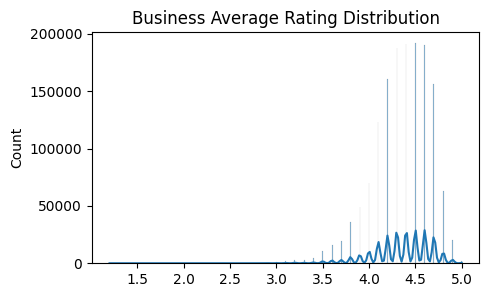

In [46]:
plt.figure(figsize=(5, 3))
sns.histplot(bus_avg_ratings, kde=True)
plt.title('Business Average Rating Distribution')

Text(0.5, 1.0, 'Number of Reviews Distribution')

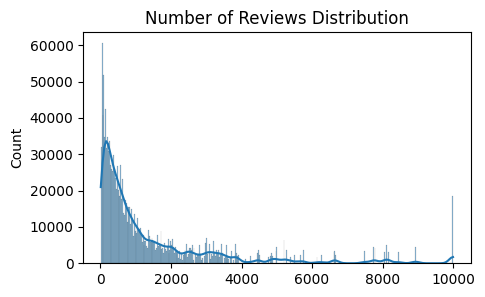

In [47]:
plt.figure(figsize=(5, 3))
sns.histplot(num_of_reviews, kde=True)
plt.title('Number of Reviews Distribution')

Text(0.5, 1.0, 'Response Counts Distribution')

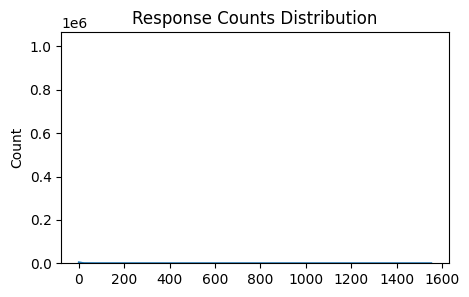

In [48]:
plt.figure(figsize=(5, 3))
sns.histplot(response_counts, kde=True)
plt.title('Response Counts Distribution')

Text(0.5, 1.0, 'Image Counts Distribution')

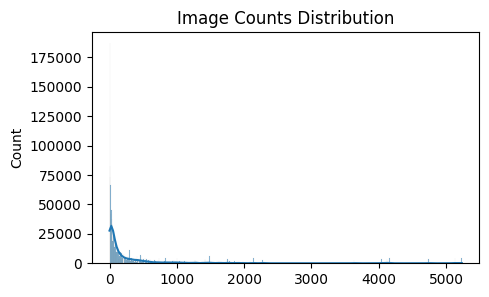

In [49]:
plt.figure(figsize=(5, 3))
sns.histplot(image_counts, kde=True)
plt.title('Image Counts Distribution')

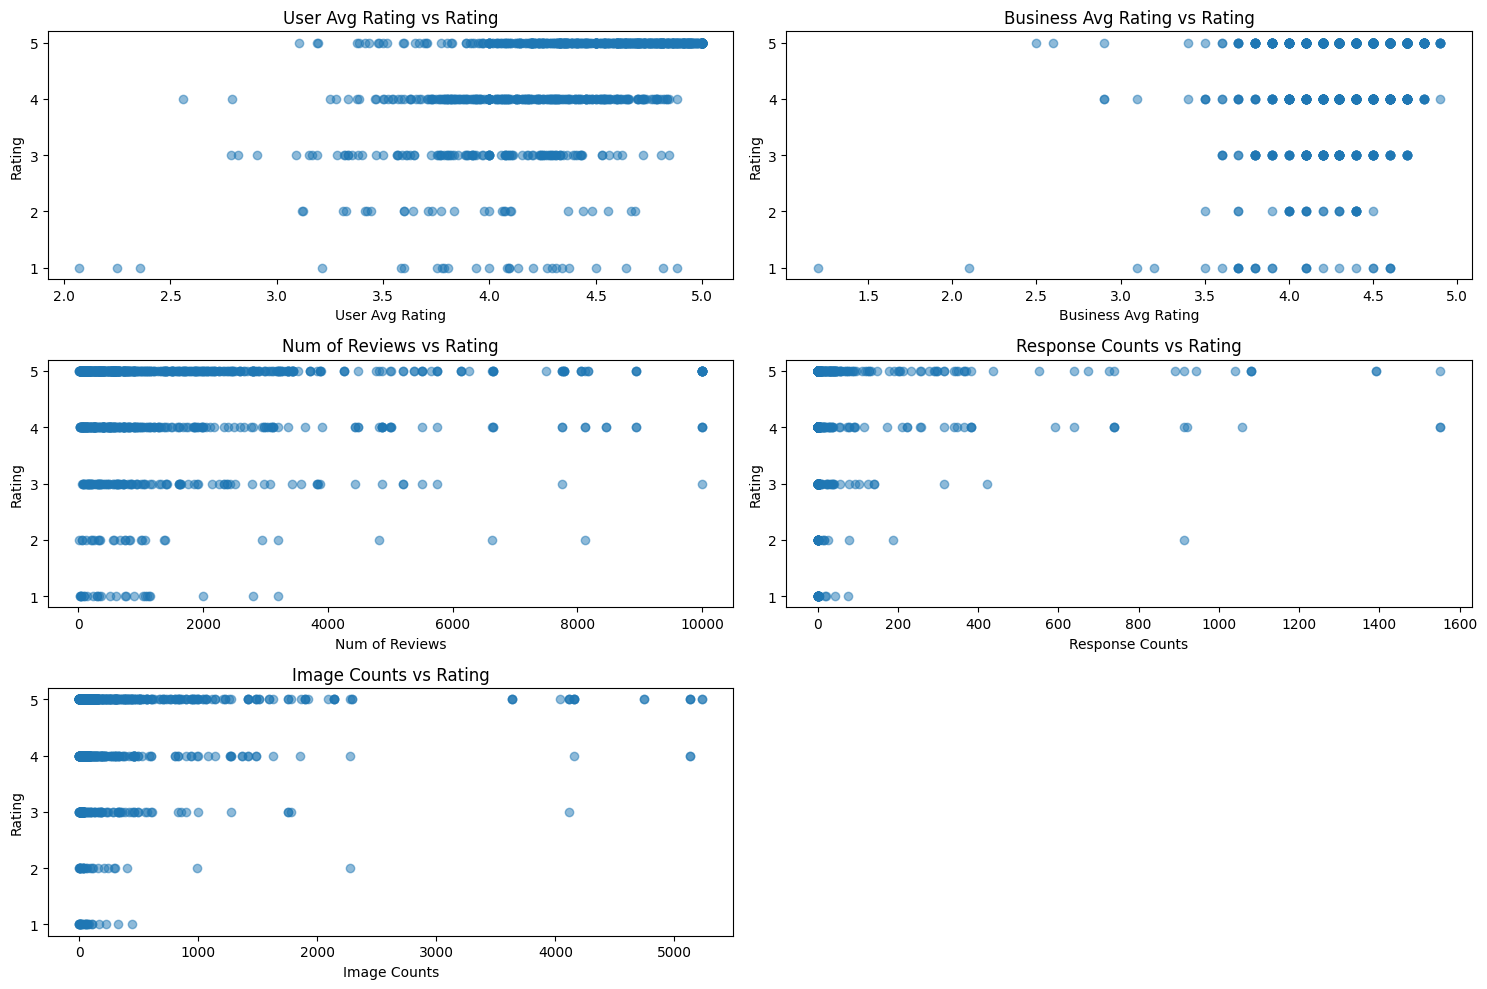

In [50]:
plt.figure(figsize=(15, 10))
for i, (feature, title) in enumerate(zip([user_avg_ratings, bus_avg_ratings, num_of_reviews, response_counts, image_counts], 
                                         ['User Avg Rating', 'Business Avg Rating', 'Num of Reviews', 'Response Counts', 'Image Counts'])):
    plt.subplot(3, 2, i+1)
    plt.scatter(feature[:1000], labels[:1000], alpha=0.5)
    plt.xlabel(title)
    plt.ylabel('Rating')
    plt.title(f'{title} vs Rating')

plt.tight_layout()
plt.show()

## Random Forest model

In [63]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

train_X = [[1, d['user_avg_rating'], d['bus_avg_rating']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating']] for d in test_features]

train_y = train_labels
test_y = test_labels


# Train the model
rf.fit(train_X, train_y)

# Make predictions
predictions = rf.predict(test_X)

# Evaluate the model
mse = mean_squared_error(test_y, predictions)
print(f'MSE: {mse}')

MSE: 0.5955926426030516


In [65]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

train_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews']] for d in test_features]

train_y = train_labels
test_y = test_labels


# Train the model
rf.fit(train_X, train_y)

# Make predictions
predictions = rf.predict(test_X)

# Evaluate the model
mse = mean_squared_error(test_y, predictions)
print(f'MSE: {mse}')

## GradientBoostingRegressor

In [69]:
train_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating'], d['num_of_reviews']] for d in test_features]

train_y = train_labels
test_y = test_labels

In [70]:
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=1, random_state=42)

gb_regressor.fit(train_X, train_y)

predictions = gb_regressor.predict(test_X)

mse = mean_squared_error(test_y, predictions)
print(f'MSE: {mse}')


MSE: 0.5684504386382397


In [73]:
train_X = [[1, d['user_avg_rating'], d['bus_avg_rating'],d['num_of_reviews'], d['image_counts']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating'],d['num_of_reviews'], d['image_counts']] for d in test_features]

train_y = train_labels
test_y = test_labels

In [74]:
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=1, random_state=42)

gb_regressor.fit(train_X, train_y)

predictions = gb_regressor.predict(test_X)

mse = mean_squared_error(test_y, predictions)
print(f'MSE: {mse}')


MSE: 0.5681635727175706


## Xgboost

In [80]:
train_X = [[1, d['user_avg_rating'], d['bus_avg_rating'],d['num_of_reviews'], d['image_counts']] for d in train_features]
test_X = [[1, d['user_avg_rating'], d['bus_avg_rating'],d['num_of_reviews'], d['image_counts']] for d in test_features]

train_y = train_labels
test_y = test_labels

In [90]:
xg_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)
xg_model.fit(train_X, train_y)
predictions = xg_model.predict(test_X)

mse = mean_squared_error(test_y, predictions)
print(f'MSE: {mse}')

MSE: 0.5674976760012402
